In [1]:
# basic modules 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial import cKDTree


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## 1. Read and explore the data

In [2]:
# Read data
#rawdf = pd.read_csv("./Parking_Citations.csv", low_memory=False)

In [3]:
#rawdf.head(5)

In [4]:
#rawdf.info()

### 1.1 Get pands timestamps from `ImportDate`

In [5]:
#%%time
#rawdf['citationtime'] = pd.to_datetime(rawdf.ViolDate)

### 1.2 Save this new `rawdf` as a parquet for later uses. 

In [6]:
import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
#pq.write_table(pa.Table.from_pandas(rawdf), 'baltimore-parking-citations.parquet.snappy', compression='snappy')

> From now on, **I will use** this `parquet` **instead of** the original `csv`

In [8]:
rawdf = pq.read_table('baltimore-parking-citations.parquet.snappy').to_pandas()

In [9]:
rawdf['citationtime'].describe()

count                 3380749
unique                1622511
top       2017-12-21 13:02:00
freq                       19
first     1999-07-27 04:11:00
last      2019-07-22 14:28:00
Name: citationtime, dtype: object

### 1.3 Trim the data by `datetime` 

In [10]:
%%time
df = rawdf[rawdf.citationtime < '2019-01-01']

CPU times: user 772 ms, sys: 143 ms, total: 915 ms
Wall time: 445 ms


In [11]:
df['citationtime'].describe()

count                 2840515
unique                1448301
top       2017-12-21 13:02:00
freq                       19
first     1999-07-27 04:11:00
last      2018-12-31 23:57:00
Name: citationtime, dtype: object

In [12]:
print len(df.index)

2840515


In [13]:
# disable some unnecessary errors
pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 10)

# 2. Questions

### 2.1 For all citations, what is the mean violation fine?

In [14]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840515 entries, 0 to 3385278
Data columns (total 22 columns):
Citation           int64
Tag                object
ExpMM              object
ExpYY              float64
State              object
Make               object
Address            object
ViolCode           int64
Description        object
ViolFine           float64
ViolDate           object
Balance            float64
PenaltyDate        float64
OpenFine           float64
OpenPenalty        float64
NoticeDate         object
ImportDate         object
Neighborhood       object
PoliceDistrict     object
CouncilDistrict    float64
Location           object
citationtime       datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(2), object(12)
memory usage: 498.4+ MB


In [15]:
df['ViolFine'].mean(skipna=True)

49.16334749156403

In [16]:
df['ViolFine'].mean(skipna=False)

49.16334749156403

### 2.2 Find all citations where the police district has been given. 

> Next, determine which district has the highest mean violation fine. What is that mean violation fine? Keep in mind that Baltimore is divided into nine police districts, so clean the data accordingly.

In [17]:
grouped = df.groupby('PoliceDistrict')

In [18]:
grouped.groups.keys()

['NORTHWESTERN',
 'NORTHEASTERN',
 'Central',
 'Northern',
 'NORTHERN',
 'EASTERN',
 'Southern',
 'Eastern',
 'SOUTHERN',
 'SOUTHEASTERN',
 'SOUTHWESTERN',
 'Notheastern',
 'WESTERN',
 'Southwestern',
 'CENTRAL',
 'Northwestern',
 'Southeastern',
 'Western']

> There is an issue about upper and lower cases

In [19]:
pddf = df.dropna(subset=['PoliceDistrict'])

In [20]:
pddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320361 entries, 434 to 3385267
Data columns (total 22 columns):
Citation           320361 non-null int64
Tag                320271 non-null object
ExpMM              310790 non-null object
ExpYY              320361 non-null float64
State              320361 non-null object
Make               319988 non-null object
Address            320361 non-null object
ViolCode           320361 non-null int64
Description        320361 non-null object
ViolFine           320361 non-null float64
ViolDate           320361 non-null object
Balance            320361 non-null float64
PenaltyDate        0 non-null float64
OpenFine           320361 non-null float64
OpenPenalty        320361 non-null float64
NoticeDate         109891 non-null object
ImportDate         320361 non-null object
Neighborhood       320361 non-null object
PoliceDistrict     320361 non-null object
CouncilDistrict    320361 non-null float64
Location           320361 non-null object
cita

In [21]:
pddf['upperPD'] = pddf['PoliceDistrict'].str.upper()

In [22]:
grouped = pddf.groupby('upperPD')

In [23]:
grouped.groups.keys()

['NORTHWESTERN',
 'CENTRAL',
 'NORTHERN',
 'EASTERN',
 'NORTHEASTERN',
 'SOUTHERN',
 'NOTHEASTERN',
 'WESTERN',
 'SOUTHWESTERN',
 'SOUTHEASTERN']

> `NOTHEASTERN`? a typo?

In [24]:
len(grouped.get_group('NOTHEASTERN'))

22539

In [25]:
pddf['correctPD'] = pddf['upperPD'].apply(lambda x: 'NORTHEASTERN' if x == 'NOTHEASTERN' else x)

In [26]:
grouped = pddf.groupby('correctPD')

In [27]:
grouped.groups.keys()

['NORTHWESTERN',
 'CENTRAL',
 'NORTHERN',
 'EASTERN',
 'NORTHEASTERN',
 'SOUTHERN',
 'WESTERN',
 'SOUTHWESTERN',
 'SOUTHEASTERN']

In [28]:
grouped['ViolFine'].mean()

correctPD
CENTRAL         44.6076459423
EASTERN         50.5977354558
NORTHEASTERN    60.9117357810
NORTHERN        47.7749682253
NORTHWESTERN    59.5697236684
SOUTHEASTERN    48.0110722173
SOUTHERN        53.7663527040
SOUTHWESTERN    58.4152159897
WESTERN         53.3284385159
Name: ViolFine, dtype: float64

> `NORTHEASTERN    60.9117357810`

### 2.3 First, find the total number of citations given in each year between 2004 and 2014 (inclusive). 

> Next, using linear regression, create a function that plots the total number of citations as a function of the year. If you were to plot a line using this function, what would be the slope of that line?

In [29]:
df[:5].citationtime.dt.year

0    2018
1    2018
2    2018
3    2018
4    2018
Name: citationtime, dtype: int64

In [30]:
# Pandas Series : the number of citations by year
psNumCits = df['citationtime'].groupby(df.citationtime.dt.year).count()

In [31]:
psNumCits

citationtime
1999         1
2000         3
2002        58
2003       148
2004       162
2005      1136
2006      5550
2007     50049
2008     41672
2009     42719
2010     45842
2011    129722
2012    160453
2013     53916
2014     79135
2015    351858
2016    351179
2017    553981
2018    972931
Name: citationtime, dtype: int64

In [32]:
psNumCits = psNumCits[4:15]

In [33]:
psNumCits.index.values

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [34]:
psNumCits.values

array([   162,   1136,   5550,  50049,  41672,  42719,  45842, 129722,
       160453,  53916,  79135])

In [35]:
from scipy import stats

In [36]:
slope, intercept, r_value, p_value, std_err =\
stats.linregress(np.double(psNumCits.index.values),np.double(psNumCits.values))

In [37]:
[slope, intercept, r_value, p_value, std_err]

[11220.090909090908,
 -22485675.727272723,
 0.728746955946906,
 0.010960659345771815,
 3514.401631325399]

In [38]:
# model prediction
ymodel = 11220.090909090908 * np.double(psNumCits.index.values) -22485675.727272723

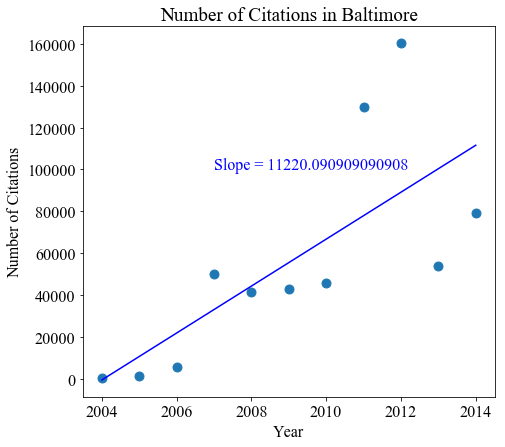

In [39]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(7,6.2))

#plt.axis([0,lenmax,0,1.0])
plt.title("Number of Citations in Baltimore")
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'Number of Citations')
plt.xlabel(r'Year')
plt.scatter(psNumCits.index.values,psNumCits.values,s=80)
plt.plot(psNumCits.index.values,ymodel,color='b')
plt.text(2007,100000,'Slope = 11220.090909090908',color='b')


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("car-accidents.eps")
plt.show()

### 2.4 Looking only at vehicles that have open penalty fees, 

> what dollar amount is the 81st percentile of that group?

In [40]:
opdf = df[df.OpenPenalty > 0.0]

In [41]:
opdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209371 entries, 18 to 3385251
Data columns (total 22 columns):
Citation           209371 non-null int64
Tag                209371 non-null object
ExpMM              206872 non-null object
ExpYY              209371 non-null float64
State              209371 non-null object
Make               208896 non-null object
Address            209371 non-null object
ViolCode           209371 non-null int64
Description        209371 non-null object
ViolFine           209371 non-null float64
ViolDate           209371 non-null object
Balance            209371 non-null float64
PenaltyDate        0 non-null float64
OpenFine           209371 non-null float64
OpenPenalty        209371 non-null float64
NoticeDate         209278 non-null object
ImportDate         209371 non-null object
Neighborhood       44791 non-null object
PoliceDistrict     44791 non-null object
CouncilDistrict    44796 non-null float64
Location           208030 non-null object
citation

In [42]:
opdf['OpenPenalty'].quantile([0.25,0.5,0.81])

0.25    144.0
0.50    300.0
0.81    480.0
Name: OpenPenalty, dtype: float64

> The answer is $480. 

In [43]:
opdf['OpenPenalty'].describe()

count    209371.0000000000
mean        285.0500833449
std         182.9468464108
min           1.0000000000
25%         144.0000000000
50%         300.0000000000
75%         325.0000000000
max        3120.0000000000
Name: OpenPenalty, dtype: float64

### 2.5 Find the ten vehicle makes that received the most citations during 2017. 

> For those top ten, find all Japanese-made vehicles. What proportion of all citations were written for those vehicles? Note that the naming in Make is not consistent over the whole dataset, so you will need to clean the data before calculating your answer. Your answer should be expressed as a decimal number (i.e. 0.42, not 42).

In [44]:
df2017 = df[df.citationtime.dt.year == 2017]

In [45]:
df2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553981 entries, 631 to 3385278
Data columns (total 22 columns):
Citation           553981 non-null int64
Tag                553898 non-null object
ExpMM              535295 non-null object
ExpYY              553981 non-null float64
State              553981 non-null object
Make               553830 non-null object
Address            553981 non-null object
ViolCode           553981 non-null int64
Description        553981 non-null object
ViolFine           553981 non-null float64
ViolDate           553981 non-null object
Balance            553981 non-null float64
PenaltyDate        0 non-null float64
OpenFine           553981 non-null float64
OpenPenalty        553981 non-null float64
NoticeDate         494 non-null object
ImportDate         553981 non-null object
Neighborhood       60563 non-null object
PoliceDistrict     60563 non-null object
CouncilDistrict    60565 non-null float64
Location           551696 non-null object
citationti

In [46]:
df2017.Make.unique()

array(['TOYT', 'HOND', 'MERZ', 'FORD', 'NISS', 'MAZD', 'BMW', 'BUIC',
       'ACUR', 'OLDS', 'CHEV', 'CHEVR', 'LINC', 'JEEP', 'INFIN', 'VOLV',
       'VOLK', 'DODG', 'CHRY', 'GMC', 'LEXUS', 'LEXU', 'UNKN', 'TOYOT',
       'UNK', 'HYUN', 'SUBA', 'KENWO', 'ACURA', 'KIA', 'UN', 'RANG',
       'ISUZ', 'MITS', 'MERC', 'CADI', 'AUDI', 'OTH', 'INTL', None,
       'PONT', 'MINI', 'SATUR', 'LAND', 'KW', 'MAZDA', 'INFI', 'SATU',
       'FAIT', 'SCION', 'FREI', 'BUICK', 'HONDA', 'RANGE', 'DODGE',
       'TRAI', 'PONTI', 'CHRYS', 'HYUND', 'HUMME', 'SAAB', 'INTER',
       'PORSH', 'VOLKS', 'RANGR', 'FORES', 'PORS', 'JAQU', 'SUZUK',
       'LANDR', 'FREIG', 'HARLE', 'YAMAH', 'FEDEX', 'JAGUA', 'VAN',
       'TRUC', 'FIAT', 'JAG', 'NISSA', 'MITSU', 'MERCE', 'ISUZU', 'GENES',
       'LNDR', 'VOLVO', 'NO ST', 'ISU', 'JAGU', 'LEXS', 'SUZI', 'RAM',
       'STRN', 'HUMM', 'VNTC', 'NEWF', 'SUZU', 'TOY', 'HEIL', 'NFLY',
       'SCIO', 'Hyund', 'NEFL', 'M B', 'JEE', 'INF', 'LEX', 'HYU', 'HD',
       'MNNI', '

> Too many **variants** for each **car maker**. Manually identify all of these variants to correct the data?

#### Ok. I will do some approximation. List all top 100 makers via citations numbers. Then, merge them for the duplicated makers

In [47]:
mkgrouped = df2017.groupby('Make')

In [48]:
psMakeCit = mkgrouped['Make'].count().sort_values(ascending=False)

In [49]:
psMakeCit[:100].index

Index([u'FORD', u'HONDA', u'TOYOT', u'NISSA', u'CHEVR', u'TOYT', u'HOND',
       u'NISS', u'CHEV', u'JEEP', u'HYUND', u'DODGE', u'HYUN', u'BMW',
       u'ACURA', u'KIA', u'VOLKS', u'DODG', u'MAZDA', u'LEXUS', u'MERCE',
       u'TRAIL', u'GMC', u'ACUR', u'CHRYS', u'SUBAR', u'CHRY', u'AUDI',
       u'MERZ', u'LEXS', u'INFIN', u'VOLK', u'BUICK', u'VOLVO', u'MAZD',
       u'INFI', u'CADIL', u'SUBA', u'BUIC', u'MITSU', u'LINCO', u'MERCU',
       u'CADI', u'PONTI', u'SATUR', u'VOLV', u'SCION', u'LINC', u'MERC',
       u'MITS', u'MINI-', u'PONT', u'LEXU', u'RAM', u'LAND', u'STRN', u'FREIG',
       u'OLDSM', u'FIAT', u'JAGUA', u'SAAB', u'SUZUK', u'RANGE', u'LNDR',
       u'ISUZU', u'INTER', u'PORSC', u'JAGU', u'OLDS', u'SATU', u'MINI',
       u'SCIO', u'MNNI', u'UNK', u'PORS', u'HON', u'HUMME', u'TOYO', u'SUZI',
       u'PLYMO', u'TOY', u'SMART', u'DETAC', u'UNKN', u'HUMM', u'FOR', u'SUZU',
       u'NIS', u'TESLA', u'SAA', u'ISU', u'PETER', u'CHE', u'ROV', u'DISP',
       u'NO PA', u'GEO', u'N

In [50]:
psMakeCit[:100].values

array([56786, 43049, 40844, 27991, 27745, 27590, 27368, 22014, 21705,
       16973, 16299, 12260, 11746, 11587, 10476,  9909,  9903,  9011,
        7995,  7483,  7276,  7258,  6891,  6867,  6704,  6552,  6211,
        4941,  4590,  4570,  4443,  4362,  3710,  3677,  3558,  3244,
        3095,  3038,  2957,  2398,  2348,  2284,  2263,  2235,  2131,
        1891,  1799,  1692,  1542,  1528,  1380,  1220,  1152,   846,
         788,   745,   724,   713,   634,   595,   592,   511,   435,
         395,   394,   373,   352,   341,   322,   296,   282,   265,
         196,   193,   185,   170,   154,   154,   151,   146,   135,
         132,   129,   129,   115,   111,   108,   102,    92,    89,
          87,    84,    81,    81,    80,    71,    71,    69,    67,
          66])

In [51]:
list(psMakeCit[:100].index.sort_values(ascending=True))

['ACUR',
 'ACURA',
 'AUDI',
 'BMW',
 'BUIC',
 'BUICK',
 'CADI',
 'CADIL',
 'CHE',
 'CHEV',
 'CHEVR',
 'CHRY',
 'CHRYS',
 'DETAC',
 'DISP',
 'DODG',
 'DODGE',
 'FEDEX',
 'FIAT',
 'FOR',
 'FORD',
 'FREIG',
 'GEO',
 'GMC',
 'HON',
 'HOND',
 'HONDA',
 'HUMM',
 'HUMME',
 'HYU',
 'HYUN',
 'HYUND',
 'INFI',
 'INFIN',
 'INTER',
 'ISU',
 'ISUZU',
 'JAGU',
 'JAGUA',
 'JEEP',
 'KIA',
 'LAND',
 'LEXS',
 'LEXU',
 'LEXUS',
 'LINC',
 'LINCO',
 'LNDR',
 'MAZD',
 'MAZDA',
 'MERC',
 'MERCE',
 'MERCU',
 'MERZ',
 'MINI',
 'MINI-',
 'MITS',
 'MITSU',
 'MNNI',
 'NIS',
 'NISS',
 'NISSA',
 'NO PA',
 'NO ST',
 'OLDS',
 'OLDSM',
 'PETER',
 'PLYMO',
 'PONT',
 'PONTI',
 'PORS',
 'PORSC',
 'RAM',
 'RANGE',
 'ROV',
 'SAA',
 'SAAB',
 'SATU',
 'SATUR',
 'SCIO',
 'SCION',
 'SMART',
 'STRN',
 'SUBA',
 'SUBAR',
 'SUZI',
 'SUZU',
 'SUZUK',
 'TESLA',
 'TOY',
 'TOYO',
 'TOYOT',
 'TOYT',
 'TRAIL',
 'UNK',
 'UNKN',
 'VOLK',
 'VOLKS',
 'VOLV',
 'VOLVO']

> **Except for `volvo` and `volks`, the first three letters are ok to discern all Makes.** So I will remove the minor maker VOLVO, then trim the maker names with the first 3 first letters.

#### Make a new column with a `sliced` name, then group by this

In [52]:
#Remove volv and volvo, which confuse with volks
dftrim = df2017[~df2017.Make.isin(['VOLV','VOLVO'])]

In [53]:
len(dftrim)

548413

In [54]:
len(df2017)

553981

In [55]:
dftrim.Make.unique()

array(['TOYT', 'HOND', 'MERZ', 'FORD', 'NISS', 'MAZD', 'BMW', 'BUIC',
       'ACUR', 'OLDS', 'CHEV', 'CHEVR', 'LINC', 'JEEP', 'INFIN', 'VOLK',
       'DODG', 'CHRY', 'GMC', 'LEXUS', 'LEXU', 'UNKN', 'TOYOT', 'UNK',
       'HYUN', 'SUBA', 'KENWO', 'ACURA', 'KIA', 'UN', 'RANG', 'ISUZ',
       'MITS', 'MERC', 'CADI', 'AUDI', 'OTH', 'INTL', None, 'PONT',
       'MINI', 'SATUR', 'LAND', 'KW', 'MAZDA', 'INFI', 'SATU', 'FAIT',
       'SCION', 'FREI', 'BUICK', 'HONDA', 'RANGE', 'DODGE', 'TRAI',
       'PONTI', 'CHRYS', 'HYUND', 'HUMME', 'SAAB', 'INTER', 'PORSH',
       'VOLKS', 'RANGR', 'FORES', 'PORS', 'JAQU', 'SUZUK', 'LANDR',
       'FREIG', 'HARLE', 'YAMAH', 'FEDEX', 'JAGUA', 'VAN', 'TRUC', 'FIAT',
       'JAG', 'NISSA', 'MITSU', 'MERCE', 'ISUZU', 'GENES', 'LNDR',
       'NO ST', 'ISU', 'JAGU', 'LEXS', 'SUZI', 'RAM', 'STRN', 'HUMM',
       'VNTC', 'NEWF', 'SUZU', 'TOY', 'HEIL', 'NFLY', 'SCIO', 'Hyund',
       'NEFL', 'M B', 'JEE', 'INF', 'LEX', 'HYU', 'HD', 'MNNI', 'FOR',
       'BLUE', 'AC

In [56]:
dftrim['MakeSlice'] = dftrim['Make'].str.slice(stop=3)

In [57]:
dftrim.MakeSlice.unique()

array(['TOY', 'HON', 'MER', 'FOR', 'NIS', 'MAZ', 'BMW', 'BUI', 'ACU',
       'OLD', 'CHE', 'LIN', 'JEE', 'INF', 'VOL', 'DOD', 'CHR', 'GMC',
       'LEX', 'UNK', 'HYU', 'SUB', 'KEN', 'KIA', 'UN', 'RAN', 'ISU',
       'MIT', 'CAD', 'AUD', 'OTH', 'INT', None, 'PON', 'MIN', 'SAT',
       'LAN', 'KW', 'FAI', 'SCI', 'FRE', 'TRA', 'HUM', 'SAA', 'POR',
       'JAQ', 'SUZ', 'HAR', 'YAM', 'FED', 'JAG', 'VAN', 'TRU', 'FIA',
       'GEN', 'LND', 'NO ', 'RAM', 'STR', 'VNT', 'NEW', 'HEI', 'NFL',
       'Hyu', 'NEF', 'M B', 'HD', 'MNN', 'BLU', 'SOM', 'MAC', 'NWF',
       'VCT', 'PLY', 'FRH', 'VPG', 'PTR', 'ROV', 'THO', 'STE', 'HIN',
       'IC', 'FRU', 'CIM', '08', 'PET', 'ROR', 'BAR', 'WST', 'PIE', 'AUT',
       'WOR', 'WES', 'SMA', 'SMR', 'MCI', 'MAS', 'STL', 'HYD', 'ICB',
       'STA', 'TES', 'TRI', 'V W', 'TSM', 'FRI', 'FLI', 'TUR', 'MG',
       'UTL', 'GTD', 'GOS', 'PAC', 'LOK', 'GEO', 'EAS', 'UD', 'FON',
       'UTI', 'G D', 'MB.', 'LAR', 'VW.', 'JEP', 'WAN', 'WAB', 'MAJ',
       'SKT', 'BEN', 

In [58]:
mkslicegrouped = dftrim.groupby('MakeSlice')

In [59]:
psMakeSliceCit = mkslicegrouped['MakeSlice'].count().sort_values(ascending=False)

In [60]:
psMakeSliceCit[:100].index

Index([u'HON', u'TOY', u'FOR', u'NIS', u'CHE', u'HYU', u'DOD', u'ACU', u'JEE',
       u'MER', u'VOL', u'LEX', u'CHR', u'BMW', u'MAZ', u'KIA', u'SUB', u'INF',
       u'TRA', u'GMC', u'BUI', u'CAD', u'AUD', u'LIN', u'MIT', u'PON', u'SAT',
       u'SCI', u'MIN', u'OLD', u'JAG', u'RAM', u'LAN', u'SUZ', u'STR', u'FRE',
       u'SAA', u'FIA', u'POR', u'ISU', u'RAN', u'INT', u'LND', u'UNK', u'HUM',
       u'PLY', u'NO ', u'MNN', u'TES', u'SMA', u'DET', u'PET', u'ROV', u'DIS',
       u'GEO', u'MAS', u'FED', u'HIN', u'STE', u'FRH', u'PAR', u'UPS', u'NEW',
       u'MAC', u'HAR', u'OTH', u'KEN', u'KAW', u'SMR', u'TRI', u'BLO', u'4-6',
       u'COM', u'HD', u'YAM', u'VPG', u'M B', u'BEN', u'EXP', u'V W', u'BLU',
       u'ABA', u'KW', u'NEF', u'GEN', u'NFL', u'VW', u'DOU', u'PAS', u'7-9',
       u'PTR', u'2HR', u'MB', u'DAE', u'THO', u'EAG', u'VAN', u'NWF', u'DUC',
       u'JAQ'],
      dtype='object', name=u'MakeSlice')

In [61]:
psMakeSliceCit[:100].values

array([70587, 68724, 56898, 50108, 49534, 28113, 21311, 17369, 17025,
       15695, 14268, 13255, 12930, 11591, 11577,  9929,  9615,  7707,
        7291,  6893,  6675,  5363,  4964,  4048,  3942,  3456,  2452,
        2069,  1664,  1037,   943,   848,   800,   774,   752,   735,
         681,   635,   543,   538,   479,   443,   402,   330,   271,
         207,   202,   196,   145,   135,   133,    94,    84,    81,
          71,    69,    68,    65,    55,    55,    50,    49,    45,
          43,    42,    35,    35,    29,    29,    27,    27,    27,
          26,    26,    26,    24,    23,    23,    22,    19,    18,
          18,    18,    18,    17,    17,    17,    16,    15,    15,
          14,    13,    13,    13,    12,    11,    11,    11,    10,
          10])

#### Finally, the top 10 makers that we need 

In [62]:
psMakeSliceCit[:10].index

Index([u'HON', u'TOY', u'FOR', u'NIS', u'CHE', u'HYU', u'DOD', u'ACU', u'JEE',
       u'MER'],
      dtype='object', name=u'MakeSlice')

> The four Japanese Makers: **Honda, Toyota, Nissan, Accura**. *But is Nissan a Japanese maker? or a French owned by Renault?*

In [63]:
psMakeSliceCit[[0,1,3,7]].index

Index([u'HON', u'TOY', u'NIS', u'ACU'], dtype='object', name=u'MakeSlice')

In [64]:
psMakeSliceCit[:10].values

array([70587, 68724, 56898, 50108, 49534, 28113, 21311, 17369, 17025,
       15695])

In [65]:
psMakeSliceCit[[0,1,3,7]].values

array([70587, 68724, 50108, 17369])

In [66]:
np.double(np.sum(psMakeSliceCit[[0,1,3,7]].values))/np.double(np.sum(psMakeSliceCit[:10].values))

0.5230319401867646

### 2.6 First, determine how many instances of auto theft ocurred in each police district during 2015. 

>Next, determine the number of parking citations that were issued in each police district during the same year. Finally, determine the ratio of auto thefts to parking citations for each district. Out of the nine police districts, what was the highest ratio?

#### 2.6.1 Auto Theft Data 

In [67]:
# Read data
crimedf = pd.read_csv("./BPD_Part_1_Victim_Based_Crime_Data.csv", low_memory=False)

In [68]:
crimedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267146 entries, 0 to 267145
Data columns (total 16 columns):
CrimeDate          267146 non-null object
CrimeTime          267124 non-null object
CrimeCode          267146 non-null object
Location           266065 non-null object
Description        267146 non-null object
Inside/Outside     238827 non-null object
Weapon             55647 non-null object
Post               265675 non-null float64
District           267146 non-null object
Neighborhood       257039 non-null object
Longitude          265722 non-null float64
Latitude           265722 non-null float64
Location 1         0 non-null float64
Premise            238572 non-null object
vri_name1          31547 non-null object
Total Incidents    267146 non-null int64
dtypes: float64(4), int64(1), object(11)
memory usage: 32.6+ MB


In [69]:
crimedf['datetime'] = pd.to_datetime(crimedf.CrimeDate)

In [70]:
crimedf['datetime'].head(5)

0   2019-07-20
1   2019-07-20
2   2019-07-20
3   2019-07-20
4   2019-07-20
Name: datetime, dtype: datetime64[ns]

In [71]:
cdf2015 = crimedf[crimedf.datetime.dt.year == 2015]

In [72]:
len(cdf2015)

48193

In [73]:
cdf2015.head(5)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,vri_name1,Total Incidents,datetime
173573,12/31/2015,18:53:00,6D,2900 OAKFORD AVE,LARCENY FROM AUTO,I,NaN,532.0,NORTHERN,PARKLANE,-76.663270638,39.341465551,NaN,UNKNOWN,NaN,1,2015-12-31
173574,12/31/2015,09:15:00,6G,4200 PENNINGTON AVE,LARCENY,I,NaN,911.0,SOUTHERN,CURTIS BAY,-76.588635000,39.227551000,NaN,OTHER - INSIDE,NaN,1,2015-12-31
173575,12/31/2015,01:45:00,3AF,4700 MORAVIA RD,ROBBERY - STREET,O,FIREARM,443.0,NORTHEAST,FRANKFORD,-76.552125152,39.326225711,NaN,STREET,NaN,1,2015-12-31
173576,12/31/2015,20:00:00,3AF,5600 NORTHWOOD AVE,ROBBERY - STREET,O,FIREARM,523.0,NORTHERN,CAMERON VILLAGE,-76.597971000,39.357816000,NaN,STREET,NaN,1,2015-12-31
173577,12/31/2015,14:00:00,7A,2100 W LAFAYETTE AVE,AUTO THEFT,O,NaN,722.0,WESTERN,MIDTOWN EDMONDSON,-76.651014000,39.298589000,NaN,STREET,NaN,1,2015-12-31


In [74]:
cdf2015.Description.unique()

array(['LARCENY FROM AUTO', 'LARCENY', 'ROBBERY - STREET', 'AUTO THEFT',
       'COMMON ASSAULT', 'ROBBERY - COMMERCIAL', 'BURGLARY',
       'AGG. ASSAULT', 'HOMICIDE', 'ARSON', 'RAPE', 'SHOOTING',
       'ROBBERY - CARJACKING', 'ROBBERY - RESIDENCE'], dtype=object)

In [75]:
autodf = cdf2015[cdf2015.Description == 'AUTO THEFT']

In [76]:
autodf.District.unique()

array(['WESTERN', 'CENTRAL', 'SOUTHWEST', 'NORTHEAST', 'NORTHWEST',
       'SOUTHERN', 'SOUTHEAST', 'EASTERN', 'NORTHERN', 'UNKNOWN'],
      dtype=object)

In [77]:
autogrouped = autodf.groupby('District')

In [78]:
psNumCrime = autogrouped['District'].count().sort_values(ascending=False)

In [79]:
psNumCrime

District
NORTHEAST    821
NORTHWEST    567
SOUTHWEST    557
WESTERN      542
NORTHERN     498
SOUTHEAST    494
SOUTHERN     453
EASTERN      336
CENTRAL      294
UNKNOWN        3
Name: District, dtype: int64

In [80]:
psNumCrime[:9].sort_index(ascending=True)

District
CENTRAL      294
EASTERN      336
NORTHEAST    821
NORTHERN     498
NORTHWEST    567
SOUTHEAST    494
SOUTHERN     453
SOUTHWEST    557
WESTERN      542
Name: District, dtype: int64

#### 2.6.2 Citation Data 

In [81]:
len(pddf)

320361

In [82]:
pddf2015 = pddf[pddf.citationtime.dt.year == 2015]

In [83]:
len(pddf2015)

62899

In [84]:
pdgrouped = pddf2015.groupby('correctPD')

In [85]:
pdgrouped['correctPD'].count()

correctPD
CENTRAL         11852
EASTERN          3125
NORTHEASTERN     4111
NORTHERN         9586
NORTHWESTERN     1731
SOUTHEASTERN    14981
SOUTHERN        12422
SOUTHWESTERN     2610
WESTERN          2481
Name: correctPD, dtype: int64

In [86]:
psNumCitation = pdgrouped['correctPD'].count()

In [87]:
np.double(psNumCrime[:9].sort_index(ascending=True).values)

array([294., 336., 821., 498., 567., 494., 453., 557., 542.])

In [88]:
np.double(psNumCitation.values)

array([11852.,  3125.,  4111.,  9586.,  1731., 14981., 12422.,  2610.,
        2481.])

In [89]:
result_ratio = np.double(psNumCrime[:9].sort_index(ascending=True).values)/np.double(psNumCitation.values)
result_ratio

array([0.02480594, 0.10752   , 0.1997081 , 0.05195076, 0.32755633,
       0.0329751 , 0.03646756, 0.21340996, 0.2184603 ])

In [90]:
psNumCitation.index.values

array(['CENTRAL', 'EASTERN', 'NORTHEASTERN', 'NORTHERN', 'NORTHWESTERN',
       'SOUTHEASTERN', 'SOUTHERN', 'SOUTHWESTERN', 'WESTERN'],
      dtype=object)

> **0.32755633 in NORTHWESTERN**